In [10]:
using DSP
using FFTW
using Plots
using Statistics
using StatsBase

# Aim 1: Low Frequency O2 to LFP Relationship

Make a formal description of the relationships between oxygen amperometric signals (<1hz) and local field potentials (LFP) (typically 1-80Hz) recorded simultaneously on separate electrodes.

## Importing Data

In [26]:
include("../helpers/importing.jl")
lfp = import_lfp("Exp 3/R1/2022-05-12_15-06-23/Record Node 101/")
o2 = import_o2("Exp 3/R1/o2LFP R1.txt")

Dict{String, Vector{Float32}} with 4 entries:
  "laser"      => []
  "sync"       => [33157.0, 43637.0, 54109.0, 64584.0, 75060.0, 85555.0, 96045.…
  "data"       => [-29.078, -31.5, -26.891, -26.938, -26.922, -28.703, -28.0, -…
  "timestamps" => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  1.75169…

## Extracting Envelopes of LFP Data

In [34]:
# Compute the Fourier Transform
sampling_rate = 1000
freqs = fftfreq(length(lfp["data"][1,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end


# Apply the Band-Pass Butterworth filter
band = [1, 5]
lfp_envelopes = []
for i in 1:4
    F = fft(lfp["data"][i, :])
    for i in 1:length(F)
        F[i] = F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
    end
    banded_lfp = real(ifft(F))
    push!(lfp_envelopes, abs.(hilbert(banded_lfp)))
end
lfp_envelopes

4-element Vector{Any}:
 Float32[0.06656944, 0.066381775, 0.066188484, 0.06598927, 0.06578391, 0.06557226, 0.065354, 0.06512898, 0.06489682, 0.0646575  …  0.06819066, 0.06804566, 0.067897454, 0.06774599, 0.06759089, 0.06743182, 0.06726859, 0.0671011, 0.06692884, 0.06675179]
 Float32[0.16497664, 0.16592766, 0.16689087, 0.16786657, 0.16885449, 0.1698548, 0.17086758, 0.17189267, 0.17293014, 0.1739801  …  0.15613763, 0.15696737, 0.1578089, 0.15866253, 0.15952808, 0.16040574, 0.16129543, 0.16219749, 0.16311157, 0.16403806]
 Float32[0.07890779, 0.07870467, 0.078496926, 0.07828462, 0.07806761, 0.07784615, 0.07762014, 0.0773896, 0.07715462, 0.07691504  …  0.08068, 0.0805241, 0.08036345, 0.080197975, 0.08002788, 0.079852924, 0.07967332, 0.07948892, 0.07929985, 0.07910617]
 Float32[0.108001724, 0.10778973, 0.107595846, 0.107420266, 0.10726372, 0.10712661, 0.10700946, 0.106912605, 0.10683658, 0.10678187  …  0.110987015, 0.110626094, 0.110277444, 0.10994178, 0.10961949, 0.1093114, 0.10901785, 0.108

## Band-Pass Filtering O2 Data

In [28]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2["data"])
freqs = fftfreq(length(o2["data"]), sampling_rate)

band = [0.1, 1] 
band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2 = real(ifft(band_pass_F))
banded_o2 = standardize(ZScoreTransform, banded_o2)

1751698-element Vector{Float32}:
 -1.7439214
 -1.8024738
 -1.8610133
 -1.9195533
 -1.9780837
 -2.0366092
 -2.0951228
 -2.1536314
 -2.2121265
 -2.2706032
  ⋮
 -1.2169373
 -1.275483
 -1.3340338
 -1.3925858
 -1.451146
 -1.5097014
 -1.5682551
 -1.6268146
 -1.6853685

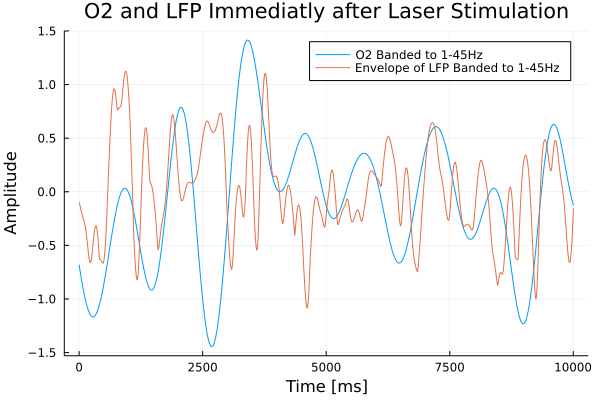

In [46]:
sync_flag = 5

o2_start = findall(x->x==o2["sync"][sync_flag], o2["timestamps"])[1]
lfp_start = findall(x->x==lfp["sync"]["on"][sync_flag], lfp["timestamps"])[1]
increment = 10000

lfp_channels_mean = zeros(increment+1)
for i in 1:4
    lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
end
lfp_channels_mean ./= 4

plot(banded_o2[o2_start:o2_start+increment], label="O2 Banded to 1-45Hz")
plot!(lfp_channels_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("O2 and LFP Immediatly after Laser Stimulation")
xlabel!("Time [ms]")
ylabel!("Amplitude")

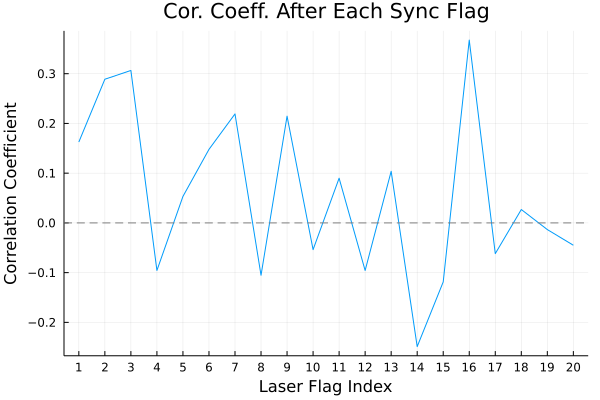

In [47]:
increment = 10000
cors = []

for flag in 1:20
    o2_start = findall(x->x==o2["sync"][flag], o2["timestamps"])[1]
    lfp_start = findall(x->x==lfp["sync"]["on"][flag], lfp["timestamps"])[1]

    lfp_channels_mean = zeros(increment+1)

    for i in 1:4
        lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
    end
    lfp_channels_mean ./= 4

    push!(cors, cor(banded_o2[o2_start:o2_start+increment], lfp_channels_mean))
end

plot(cors, legend=false)
title!("Cor. Coeff. After Each Sync Flag")
xlabel!("Laser Flag Index")
hline!([0], linestyle=:dash, colour=:grey)
xticks!((1:20))
ylabel!("Correlation Coefficient")